# Image Recognition on plant health with ConvNeXt
*by 3 Pentium 4 in a trenchcoat: Pier Luigi Porri, Davide Edoardo Pellegrino, Lorenzo Morelli*

In this notebook we try to train and test a competent binary classification model on a dataset of about 5000 images of plants. Our model of choice is ConvNeXt, imported from the Tensorflow package, specifically the Large version (*apologies for the size*).
Every choice, both structural and stylistic, will be explained either in a markdown cell or in code comments.

## Imports
First, we import what we need and we setup some things.

In [ ]:
seed = 42                           #we set the seed for the random aspect.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings                     #ignore the warnings for a cleaner output.
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

!pip install tensorflow==2.14.0    #2.14 is necessary for ConvNeXt. For some reason.
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler        #this oversampler will be useful in preprocessing.
from imblearn.combine import SMOTETomek

## Loading and processing the dataset

In [2]:
data = np.load('/kaggle/input/plants/public_data.npz', allow_pickle=True)
images = data['data']
labels = data['labels']
label_map = {0: 'healthy', 1: 'unhealthy'}                      # we map the labels for later.

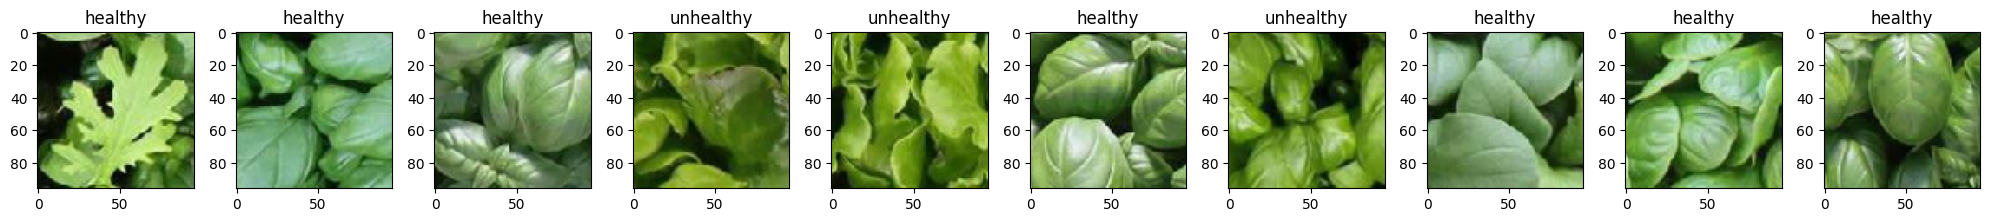

In [3]:
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(images[i]/255)
    ax.set_title(f'{labels[i]}')  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

### Finding and deleting the outliers
We found through some dataset exploration (*or by accident if you prefer to call it that way*) that the dataset, which is supposed to only contain images of plants, presents some very peculiar samples.

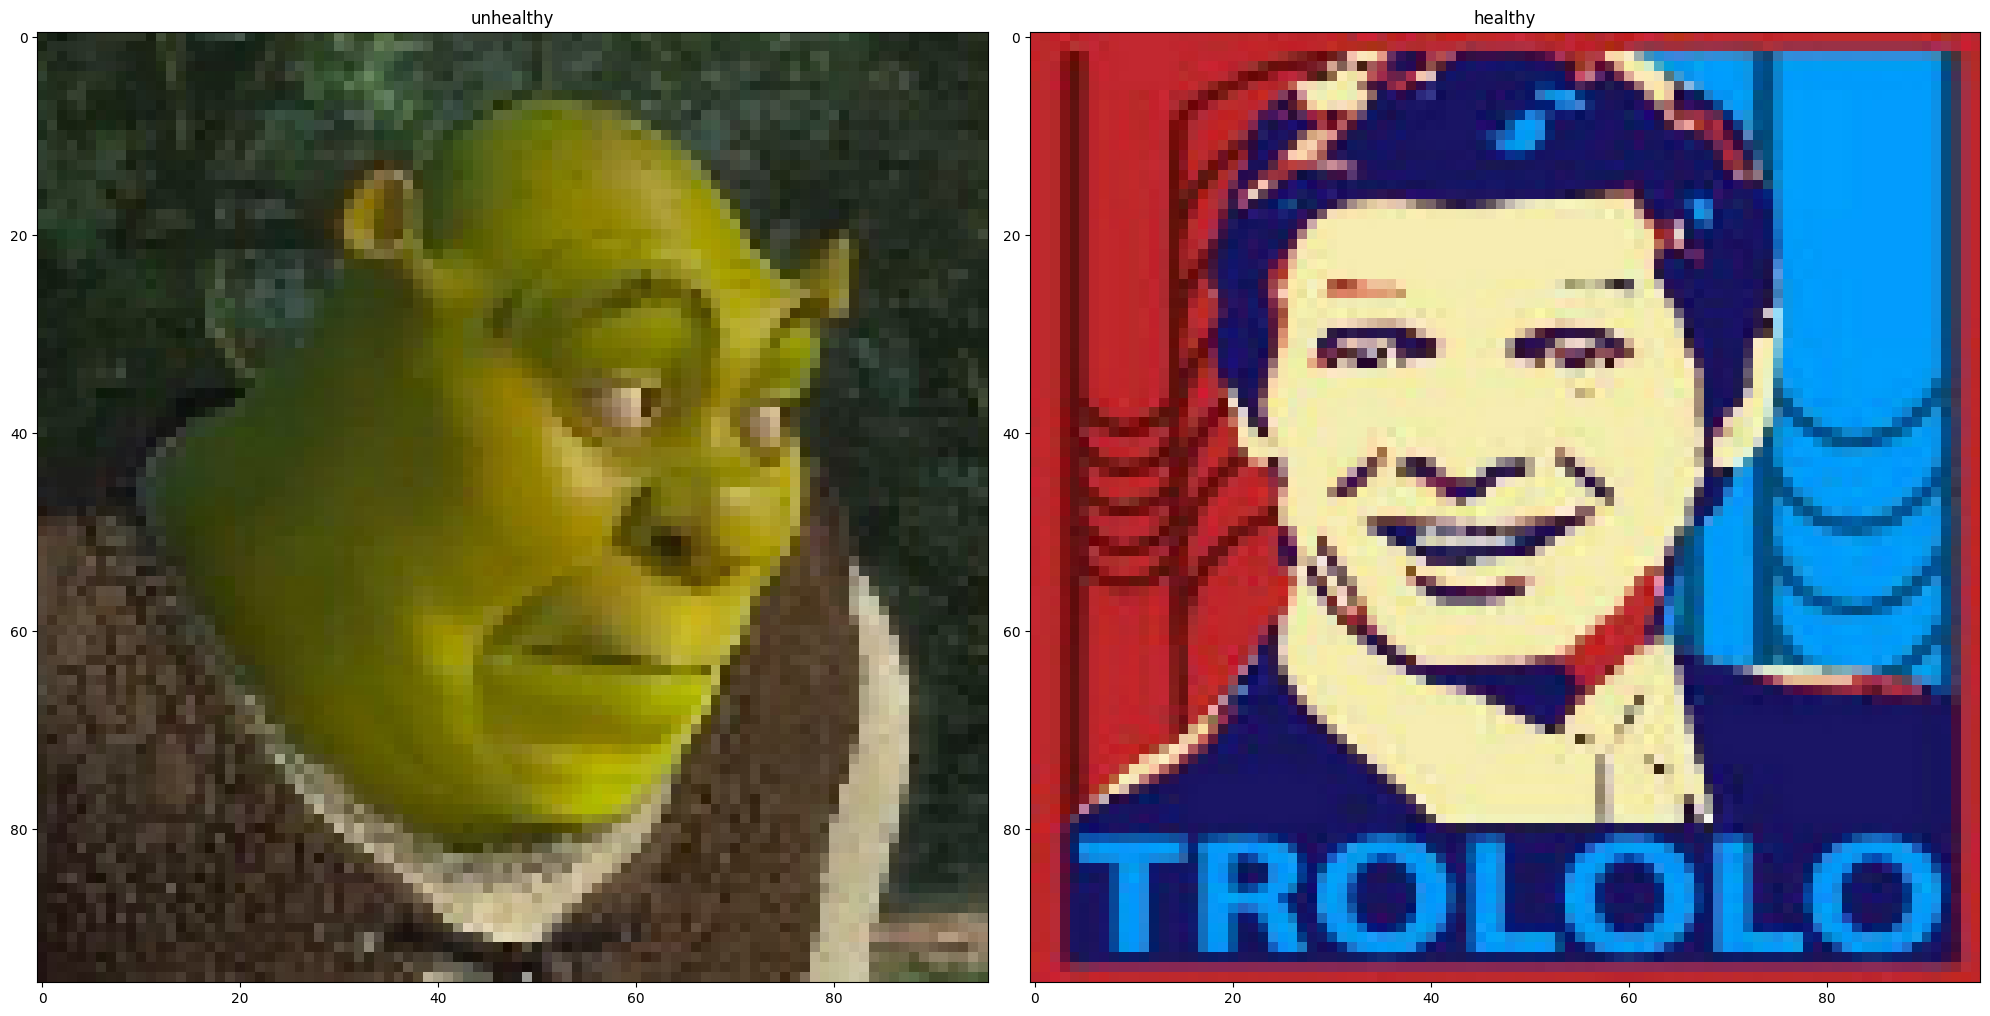

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
ax = axes[0]
ax.imshow(images[58]/255)
ax.set_title(f'{labels[58]}')
ax = axes[1]
ax.imshow(images[338]/255)
ax.set_title(f'{labels[338]}')
plt.tight_layout()
plt.show()

Since the whole purpose of our model will be classifying images of plants, we don't need whatever these are. So we find every copy and delete them.

In [5]:
same_images = []
for index, item in enumerate(images):
    if np.array_equal(item, images[58]) or np.array_equal(item, images[338]):
        same_images.append(index)

images = np.delete(images, same_images, axis=0)
labels = np.delete(labels, same_images)

We can now check how many images we deleted, and how the dataset looks.

In [6]:
print(len(same_images))
print(images.shape)
print(labels.shape)
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['labels'])['labels'].value_counts())

196

(5004, 96, 96, 3)

(5004,)

Counting occurrences of target classes:

labels

healthy      3101

unhealthy    1903

Name: count, dtype: int64


### Oversampling the minority class
It's apparent to see that the dataset is very unbalanced towards the "healthy" label. Some resampling is in order.
Through testing we found that the imblearn oversampler ADASYN yelds the better results. So, we proceed to oversample the "unhealthy" class, hoping to reach a more balanced state between classes.
Since the oversampler works on two dimensional shapes, we need to temporarily reshape our dataset. We'll turn it back to 4 dimensions later.

In [7]:
sampler = RandomOverSampler(random_state=seed)

# Reshape images to be two-dimensional
images_reshaped = images.reshape((images.shape[0], -1))
images, labels = sampler.fit_resample(images_reshaped, labels)

print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['labels'])['labels'].value_counts())

# Reshape images back to their original format
images = images.reshape((-1, 96, 96, 3))
print(images.shape)

Counting occurrences of target classes:

labels

healthy      3101

unhealthy    3101

Name: count, dtype: int64

(6202, 96, 96, 3)


### Encoding and splitting
Now the dataset looks much better. We can proceed with the encoding of the labels and the splitting.

In [8]:
y = LabelEncoder().fit_transform(labels)

test_size = 0.1

X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    y,
    random_state = seed,
    test_size = test_size,
    stratify = y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state = seed,
    test_size = test_size,
    stratify = y_train_val
)

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (5022, 96, 96, 3)

Training Label Shape: (5022,)

Test Data Shape: (621, 96, 96, 3)

Test Label Shape: (621,)

Validation Data Shape: (559, 96, 96, 3)

Validation Label Shape: (559,)


## Training the model

Now it's time for the fun part.

We first define some useful parameters for later. Most, if not all, were found through testing.

In [9]:
input_shape = X_train.shape[1:]     # Input shape for the model
output_shape = 1                    # Output shape for the model
batch_size = 32                     # Batch size for training
epochs = 350                        # Number of training epochs
patience = 30                       # patience for early stopping
dropout_rate = 0.35                 # dropout rate for the dropout layer
augmentation = tfk.Sequential([     # the data augmentation layer to mitigate overfitting. Random rotation and flip seem to be the best performing techniques.
        tfkl.RandomRotation(factor=(-0.3,0.3)),
        tfkl.RandomFlip("horizontal_and_vertical"),
    ], name='augmentation')

callbacksTL = [                     # early stopping, again to mitigate overfitting.
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)
]

callbacksFT = [                     # early stopping for the Fine tuning phase.
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Monitor the validation loss
    factor=0.1,                     # Reduce by a factor of 0.1 (i.e., lr *= factor)
    patience=10,                    # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-9                     # Lower bound on the learning rate
    )
]

optimizerTL = tfk.optimizers.Adam()

As mentioned, our model of choice will be ConvNeXt Large. We load some pre-trained weights from imagenet to help with the Transfer Learning.
The NN also includes a Global Average Pooling layer at the end, as well as a much needed preprocessing layer at the top, since it needs inputs between (0,1) and our dataset currently sits in (0,255).

In [ ]:
ConvNeXtLarge_base = tfk.applications.ConvNeXtLarge(        
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
    include_preprocessing=True,
)

tfk.utils.plot_model(ConvNeXtLarge_base, show_shapes=True)

We now build our model, adding a dense dropout layer at the output. Our activation function of choice, being binary classification with only 1 output neuron, is the sigmoid function.

In [11]:
inputs = tfk.Input(shape=input_shape)
x = augmentation(inputs)
x = ConvNeXtLarge_base(x)
x = tfkl.Dropout(dropout_rate)(x)
outputs = tfkl.Dense(1, activation='sigmoid')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

model.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         

                                                                 

 augmentation (Sequential)   (None, 96, 96, 3)         0         

                                                                 

 convnext_large (Functional  (None, 1536)              196230336 

 )                                                               

                                                                 

 dropout (Dropout)           (None, 1536)              0         

                                                                 

 dense (Dense)               (None, 1)                 1537      

                                                                 


Total params: 196231873 (748.57 MB)

Trainable params: 196231873 (748.57 MB)

Non-trainable params: 0 (0.00 Byt

### Transfer Learning
We now begin with the first phase of training, the Transfer Learning.
We proceed to freeze all the layers of our NN and then to a first training round.

In [12]:
ConvNeXtLarge_base.trainable = False
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=optimizerTL, metrics=['accuracy'])

# Train the model
tl_history = model.fit(
    x = X_train, 
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val), 
    callbacks = callbacksTL
).history

model.save('ConvNeXtLarge_TL')

Epoch 1/350

157/157 [==============================] - 64s 240ms/step - loss: 0.6283 - accuracy: 0.6740 - val_loss: 0.4861 - val_accuracy: 0.7513

Epoch 2/350

157/157 [==============================] - 25s 157ms/step - loss: 0.4740 - accuracy: 0.7674 - val_loss: 0.4188 - val_accuracy: 0.8032

Epoch 3/350

157/157 [==============================] - 25s 157ms/step - loss: 0.4318 - accuracy: 0.7989 - val_loss: 0.4107 - val_accuracy: 0.8050

Epoch 4/350

157/157 [==============================] - 25s 157ms/step - loss: 0.4124 - accuracy: 0.8104 - val_loss: 0.3878 - val_accuracy: 0.8229

Epoch 5/350

157/157 [==============================] - 25s 157ms/step - loss: 0.3958 - accuracy: 0.8182 - val_loss: 0.3858 - val_accuracy: 0.8247

Epoch 6/350

157/157 [==============================] - 24s 153ms/step - loss: 0.3876 - accuracy: 0.8206 - val_loss: 0.3871 - val_accuracy: 0.8140

Epoch 7/350

157/157 [==============================] - 24s 154ms/step - loss: 0.3810 - accuracy: 0.8355 - val_l

We can now see how it went.

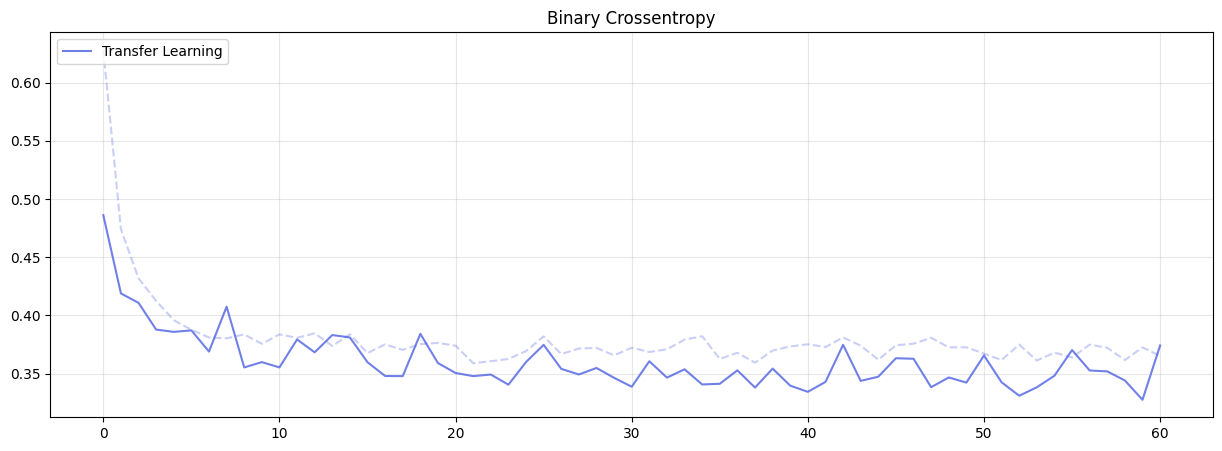

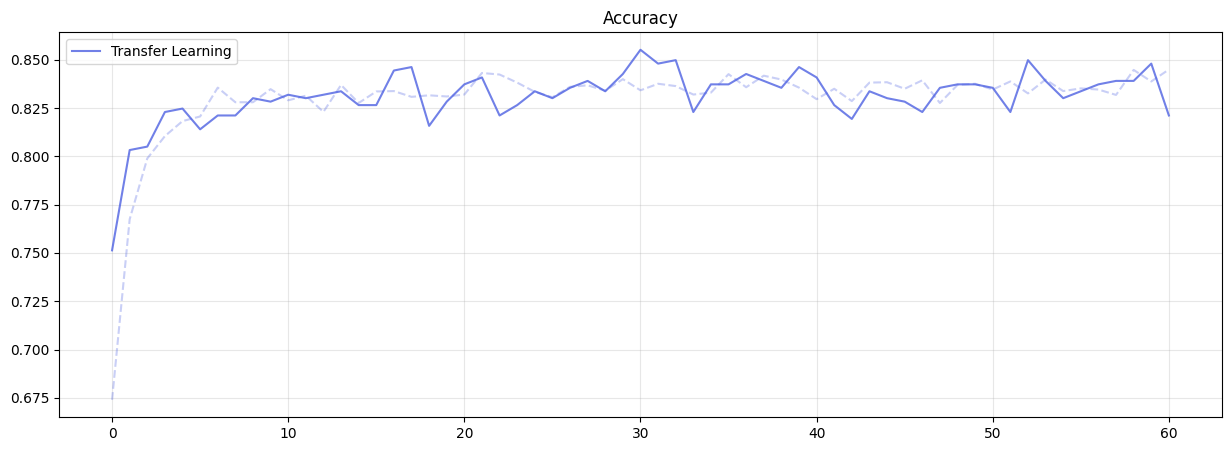

In [13]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Fine Tuning
Time for the second phase: Fine Tuning.
We define a finetuning function which takes as input the number of layers to freeze and the learning rate to start from. It will unfreeze all layers, then freeze them again up to the specified one, then it will begin a training round.

In [14]:
model = tfk.models.load_model('ConvNeXtLarge_TL')

# Freeze first N layers
def finetuning(N, lr):
    model.get_layer('convnext_large').trainable = True
    for i, layer in enumerate(model.get_layer('convnext_large').layers[:N]):
        layer.trainable=False
    
    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

    # Fine-tune the model
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_val, y_val), 
        callbacks = callbacksFT,
        verbose = 2
    ).history
    
    return history, model

We elect to fine tune the model 3 times. Thus, we proceed to load the layer indexes to freeze at each fine tuning round, as well as the initial learning rates. We'll freeze block by block, freezing one more at each round, starting from the last one.
Then, we start the process.

In [15]:
finetune_indices = [286, 278, 269]
learning_rates = [1e-5, 1e-5, 1e-5]

for i in range(len(finetune_indices)):
    history, model = finetuning(finetune_indices[i], learning_rates[i])
    print('*********************************** TEST SET ACCURACY #' + str(i) + ': %.4f' % model.evaluate(X_test, y_test, verbose=0)[-1])

Epoch 1/350

157/157 - 59s - loss: 0.3523 - accuracy: 0.8485 - val_loss: 0.3443 - val_accuracy: 0.8390 - lr: 1.0000e-05 - 59s/epoch - 373ms/step

Epoch 2/350

157/157 - 25s - loss: 0.3610 - accuracy: 0.8403 - val_loss: 0.3494 - val_accuracy: 0.8372 - lr: 1.0000e-05 - 25s/epoch - 157ms/step

Epoch 3/350

157/157 - 25s - loss: 0.3511 - accuracy: 0.8491 - val_loss: 0.3404 - val_accuracy: 0.8408 - lr: 1.0000e-05 - 25s/epoch - 159ms/step

Epoch 4/350

157/157 - 25s - loss: 0.3497 - accuracy: 0.8483 - val_loss: 0.3425 - val_accuracy: 0.8390 - lr: 1.0000e-05 - 25s/epoch - 157ms/step

Epoch 5/350

157/157 - 25s - loss: 0.3534 - accuracy: 0.8415 - val_loss: 0.3447 - val_accuracy: 0.8408 - lr: 1.0000e-05 - 25s/epoch - 157ms/step

Epoch 6/350

157/157 - 25s - loss: 0.3499 - accuracy: 0.8393 - val_loss: 0.3446 - val_accuracy: 0.8372 - lr: 1.0000e-05 - 25s/epoch - 157ms/step

Epoch 7/350

157/157 - 25s - loss: 0.3591 - accuracy: 0.8451 - val_loss: 0.3443 - val_accuracy: 0.8426 - lr: 1.0000e-05 - 25

We can now check how it went, compared to the Transfer Learned model.

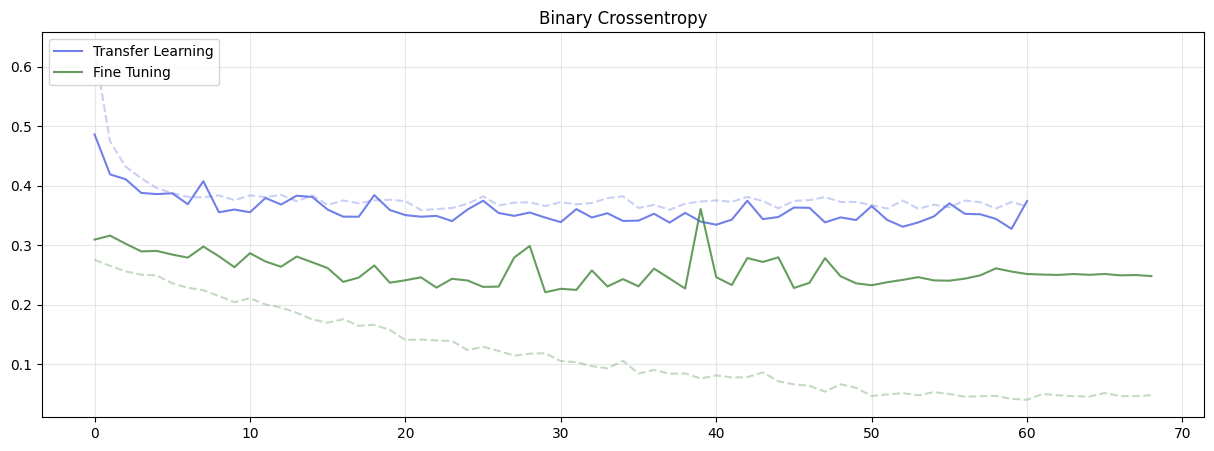

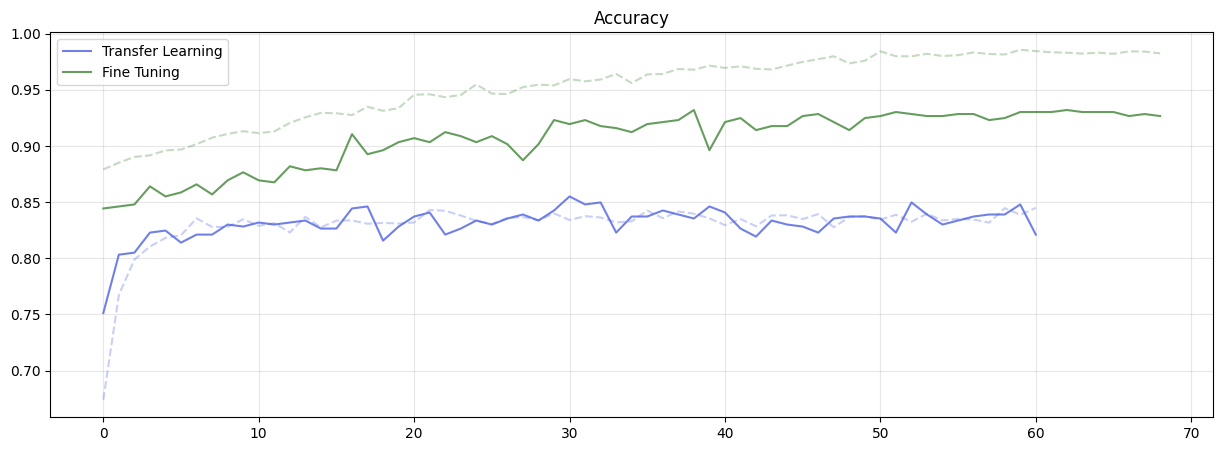

In [16]:
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [17]:
model.save('ConvNeXtLarge')

## Test on your own data
Time to test the model. We'll test it on our test set, then print the confusion matrix.

In [18]:
predictions = model.predict(X_test, verbose=0)
predictions = tf.round(predictions)
predictions = tf.squeeze(predictions)

Accuracy: 0.9211

Precision: 0.9215

Recall: 0.9211

F1: 0.9211


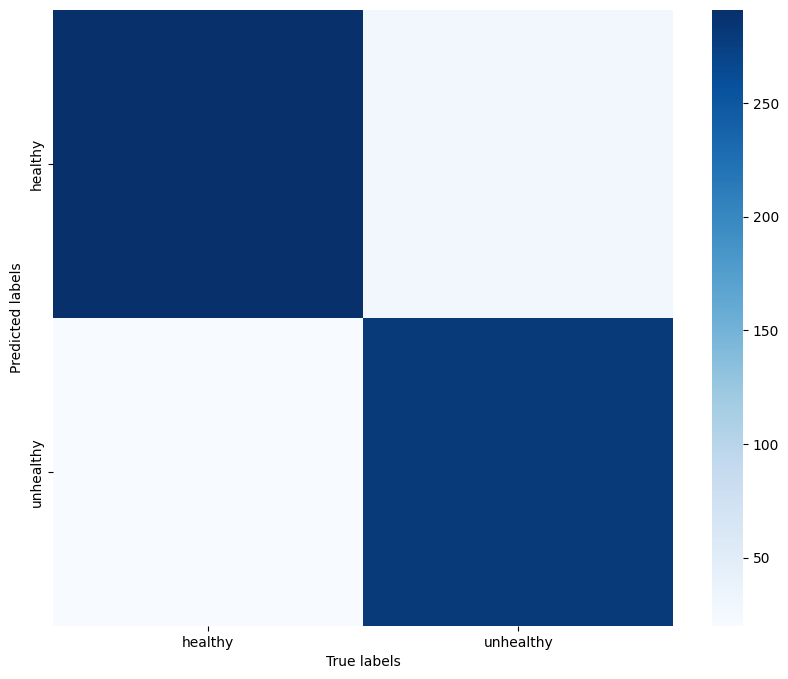

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()